### Configure the Spark Context

This code is adapted from: https://colab.research.google.com/drive/1Vyg-mF3Uzu5B432oZS3nYyV3gIfdnOqh#scrollTo=94Ts396zKTcr

In [64]:
def setupSpark():
  # Spark needs to run with Java 8 ... 
  !pip install -q findspark
  !apt-get install openjdk-8-jdk-headless > /dev/null
  !echo 2 | update-alternatives --config java > /dev/null
  # !java -version
  import os, findspark
  os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
  # !echo JAVA_HOME=$JAVA_HOME
  !pip install -q pyspark
  findspark.init(spark_home='/usr/local/lib/python3.6/dist-packages/pyspark')
  !pyspark --version


setupSpark()

/usr/local/bin/pyspark: line 24: /usr/local/lib/python3.6/dist-packages/pyspark/bin/load-spark-env.sh: No such file or directory
/usr/local/bin/pyspark: line 68: /usr/local/lib/python3.6/dist-packages/pyspark/bin/spark-submit: No such file or directory


In [5]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
    
spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("WARN")

## Read in Dataset

In [65]:
from pyspark.sql.functions import *

In [66]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
filePath = "drive/MyDrive/Colab Notebooks/comments.csv.xls"
comments_df = spark.read.format("csv").option("header","true").load(filePath)


In [59]:
## push comments to textfile
comments = comments_df.toPandas()
comments["comment_text"].to_csv('drive/MyDrive/Colab Notebooks/comments.txt', sep="\n", index=False)

In [9]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [13]:
## upvotes is a string, we want it to be an int
comments_df = comments_df.withColumn('upvotes', col('upvotes').cast('int'))

In [14]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- timestamp: string (nullable = true)



## Exploratory Data Analysis

### Average Upvote Number

In [22]:
import pandas as pd
import pyspark as ps

In [35]:
## mode of upvotes
comments_df.groupby("upvotes").count().orderBy("count", ascending=False).show()

+-------+------+
|upvotes| count|
+-------+------+
|      0|319914|
|      1|165434|
|      2| 78840|
|      3| 47820|
|   null| 38887|
|      4| 32103|
|      5| 23187|
|      6| 17890|
|      7| 13707|
|      8| 11220|
|      9|  9186|
|     10|  7585|
|     11|  6438|
|     12|  5525|
|     13|  4810|
|     14|  4378|
|     15|  3849|
|     16|  3524|
|     17|  3148|
|     18|  2972|
+-------+------+
only showing top 20 rows



In [40]:
# avg of upvotes
comments_df.select(mean('upvotes')).collect()

[Row(avg(upvotes)=8.424066809609668)]

### Unique Comments

In [25]:
comments_df.select('comment_text').distinct().count()

714965

## Word Frequency

In [67]:
data_file = 'drive/MyDrive/Colab Notebooks/comments.txt'
# take file and distribute it across worker nodes
comments_rdd = sc.textFile(data_file)

In [68]:
comments_rdd.take(20)

['comment_text',
 'Old video...come on pornhub...you can do better than this',
 'Wow 😍',
 'Does anyone know what is the IG account from this channel ?',
 'Clickbait in porn... I just totally lost my faith in humanity.',
 'I would definitely suck a fart out of your asshole!',
 'Super hot, why lie',
 'big toys are fine, but you make me die when you stick your fingers in the A-hole. oh fuck i cummed',
 "This is great. I can't relax in front of the camera like that",
 '❤',
 'love',
 'просто классная девчонка 😍',
 'I’m obsessed!! Your content is amazing 🤫',
 'Amazing content OMG 🔥😍',
 'i love being a lesbian',
 'me too',
 'Better without music.',
 'perfect vid!',
 'Spreads legs love it',
 'Yummy!!!!']

In [69]:
def clean_text(x):
  punc = '!"#$&\'()*+,.:;<=>?@[\\]^_`{|}~-'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

In [70]:
comments_rdd = comments_rdd.map(clean_text)

In [71]:
comments_rdd.take(20)

['commenttext',
 'old videocome on pornhubyou can do better than this',
 'wow 😍',
 'does anyone know what is the ig account from this channel ',
 'clickbait in porn i just totally lost my faith in humanity',
 'i would definitely suck a fart out of your asshole',
 'super hot why lie',
 'big toys are fine but you make me die when you stick your fingers in the ahole oh fuck i cummed',
 'this is great i cant relax in front of the camera like that',
 '❤',
 'love',
 'просто классная девчонка 😍',
 'i’m obsessed your content is amazing 🤫',
 'amazing content omg 🔥😍',
 'i love being a lesbian',
 'me too',
 'better without music',
 'perfect vid',
 'spreads legs love it',
 'yummy']

In [72]:
# split sentence into word list
comments_rdd = comments_rdd.flatMap(lambda x: x.split(" "))

In [73]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [74]:
# exlude any whitespaces
comments_rdd = comments_rdd.filter(lambda x: x != '')

In [75]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [79]:
## count
comments_count = comments_rdd.map(lambda word:(word,1))
comments_count.take(5)

[('commenttext', 1),
 ('old', 1),
 ('videocome', 1),
 ('on', 1),
 ('pornhubyou', 1)]

In [80]:
# reduce by key
comments_rbk = comments_count.reduceByKey(lambda x, y:(x+y)).sortByKey()
comments_rbk.take(20)

[('\x100', 1),
 ('%', 27),
 ('%%', 1),
 ('%100', 4),
 ('%15', 1),
 ('%50', 1),
 ('%90', 1),
 ('%appdata%', 6),
 ('%e6%9e%83%e7%80%9b%e6%a5%8b%e7%b4%99%e9%97%88%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%9b%b4%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%a5%b3%ef%bc%88%e6%b6%93%e5%93%84%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%202020%20%ef%bc%88%e7%82%b9%ef%bc%89c%ef%bc%8co%ef%bc%8cm%20%e5%8b%92%20%20%e4%ba%ab%20%e5%95%86%20%e5%8a%a1',
  1),
 ('%e7%b6%8b%e6%9d%88%e6%92%b3%e5%8f%86%e7%bb%be%ee%88%9d%e5%ab%b3%e9%8f%82%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e9%97%88%ef%bc%89%e5%9b%b4%ef%bc%88%e9%97%88%ef%bc%89%e5%a5%b3%ef%bc%88%e9%97%88%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%202020%20%ef%bc%88%e7%82

In [81]:
# rank words in descending order
comments_rbk = comments_rbk.map(lambda x: (x[1],x[0]))
comments_rbk.take(5)

[(1, '\x100'), (27, '%'), (1, '%%'), (4, '%100'), (1, '%15')]

In [82]:
comments_rbk.sortByKey(False).take(20)

[(201269, 'i'),
 (179937, 'the'),
 (141744, 'a'),
 (140830, 'to'),
 (127972, 'you'),
 (122113, 'is'),
 (114712, 'and'),
 (90444, 'this'),
 (85759, 'that'),
 (85645, 'so'),
 (83623, 'her'),
 (78121, 'love'),
 (75518, 'my'),
 (68426, 'of'),
 (67390, 'in'),
 (67007, 'she'),
 (64754, 'it'),
 (64238, 'me'),
 (63040, 'hot'),
 (60888, 'like')]

In [83]:
# now, remove stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [85]:
comments_rbk = comments_rbk.filter(lambda x: x[1] not in stopwords).sortByKey(False)
comments_rbk.sortByKey(False).take(20)

[(78121, 'love'),
 (63040, 'hot'),
 (60888, 'like'),
 (46163, 'video'),
 (35811, 'fuck'),
 (32933, 'would'),
 (32373, 'pussy'),
 (32365, 'sexy'),
 (29165, 'girl'),
 (28452, 'nice'),
 (27856, 'ass'),
 (25518, 'want'),
 (25164, 'name'),
 (24563, 'good'),
 (24170, 'beautiful'),
 (23189, 'cock'),
 (23134, 'one'),
 (22689, 'fucking'),
 (22390, 'great'),
 (21859, 'amazing')]

In [86]:
# now, plot
top_20_words = comments_rbk.sortByKey(False).take(20)

In [109]:
# create dictionary from list
indexes = [i for i in range(20)][::-1]
labels = [i[1] for i in top_20_words][::-1]
values = [i[0] for i in top_20_words][::-1]

In [99]:
import matplotlib.pyplot as plt

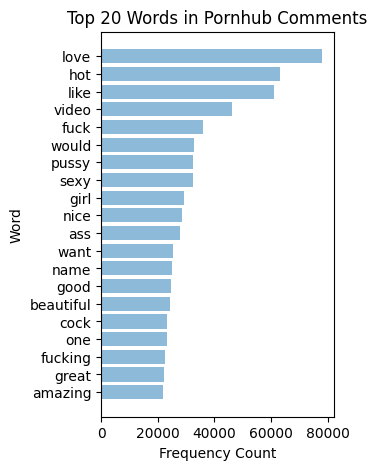

In [117]:
bar_width = 0.35

bar_width = 0.35

fig = plt.figure() 
fig.set_size_inches(3,5)

plt.barh(indexes, values, alpha=0.5)

# add labels
plt.yticks(indexes, labels, fontsize=10)
plt.xlabel('Frequency Count', fontsize=10)
plt.ylabel('Word', fontsize=10)
plt.title('Top 20 Words in Pornhub Comments', fontsize=12)
plt.gca().invert_yaxis()
plt.show()